In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import micromagneticdata as md

In [2]:
l=300e-9
w=100e-9
p1=(-l,-w,0)
p2=(l,w,3e-9)
region=df.Region(p1=p1,p2=p2)
subregions={'bottom':df.Region(p1=(-l,-w,0),p2=(l,w,1e-9)),
            'spacer':df.Region(p1=(-l,-w,1e-9),p2=(l,w,2e-9)),
            'top':df.Region(p1=(-l,-w,2e-9),p2=(l,w,3e-9))}
cell=(2e-9,2e-9,1e-9)
mesh=df.Mesh(region=region,cell=cell,subregions=subregions)

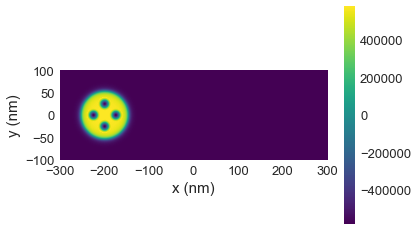

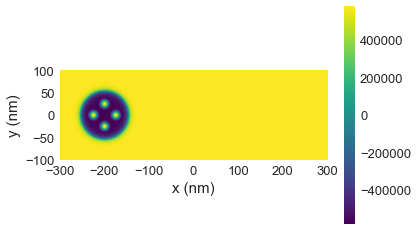

In [3]:
system=mm.System(name='logic_gate1')
Ms={'bottom':0.58e6,'spacer':0,'top':0.58e6}
A=15e-12
D={'bottom':3.8e-3,'spacer':0,'top':3.8e-3}
def K_fun(pos):
    x,y,z=pos
    if -10e-9 <= x <= 10e-9 :
        return 1.1e6
    else :
        return 0.8e6
K=df.Field(mesh,dim=1,value=K_fun)
def m_init(pos):
    R1=15e-9
    R2=80e-9
    x,y,z=pos[0],pos[1],pos[2]
    r=np.sqrt((x+200e-9)**2+y**2)
    r1=np.sqrt((x+225e-9)**2+y**2)
    r2=np.sqrt((x+175e-9)**2+y**2)
    r3=np.sqrt((x+200e-9)**2+(y+25e-9)**2)
    r4=np.sqrt((x+200e-9)**2+(y-25e-9)**2)
    phi=np.arctan2(y,x+200e-9)
    phi1=np.arctan2(y,x+225e-9)
    phi2=np.arctan2(y,x+175e-9)
    phi3=np.arctan2(y+25e-9,x+400e-9)
    phi4=np.arctan2(y-25e-9,x+400e-9)
    k1=np.pi / R1
    k2=np.pi / (R2)
    mx1=np.sin(k1*r1)*np.cos(phi1)
    my1=np.sin(k1*r1)*np.sin(phi1)
    mz1=-np.cos(k1*r1)
    mx2=np.sin(k1*r2)*np.cos(phi2)
    my2=np.sin(k1*r2)*np.sin(phi2)
    mz2=-np.cos(k1*r2)
    mx3=np.sin(k1*r3)*np.cos(phi3)
    my3=np.sin(k1*r3)*np.sin(phi3)
    mz3=-np.cos(k1*r3)
    mx4=np.sin(k1*r4)*np.cos(phi4)
    my4=np.sin(k1*r4)*np.sin(phi4)
    mz4=-np.cos(k1*r4)
    mx=np.sin(k2*(r))*np.cos(np.pi-phi)
    my=np.sin(k2*(r))*np.sin(-phi)
    mz=5*(np.cos(k2*r)+0.5)
    if 0 <= z < 1e-9:
        if r1 < R1:
            return (mx1,my1,mz1)
        elif r2 < R1:
            return (mx2,my2,mz2)
        elif r3 < R1:
            return (mx3,my3,mz3)
        elif r4 < R1:
            return (mx4,my4,mz4)
        elif r < R2 :
            return (mx,my,mz)
        else:
            return (0,0,-1)
    else :
        if r1 < R1:
            return (mx1,my1,-mz1) 
        elif r2 < R1:
            return (mx2,my2,-mz2)
        elif r3 < R1:
            return (mx3,my3,-mz3)
        elif r4 < R1:
            return (mx4,my4,-mz4)
        elif r < R2 :
            return (mx,my,-mz)
        else:
            return (0,0,1)
system.energy=mm.Exchange(A=A)+mm.DMI(D=D,crystalclass='Cnv')\
                 +mm.UniaxialAnisotropy(K=K,u=(0,0,1))\
                 +mm.Demag()+mm.RKKY(sigma=-1e-3,sigma2=0,subregions=['bottom','top'])
system.dynamics=mm.Precession(gamma0=mm.consts.gamma0)+mm.Damping(alpha=0.3)
system.m=df.Field(mesh,dim=3,value=m_init,norm=Ms)
docker_runner = oc.oommf.DockerOOMMFRunner(image='ubermag/oommf')
system.m.z.plane(z=0).mpl_scalar(filter_field=system.m.z)
system.m.z.plane(z=3e-9).mpl_scalar(filter_field=system.m.z)

In [9]:
system.dynamics+=mm.ZhangLi(u=200,beta=0.4)
td=oc.TimeDriver()
td.drive(system,t=1.5e-9,n=20,runner=docker_runner)

Running OOMMF (DockerOOMMFRunner) [2021/07/02 21:17]... (1276.4 s)


In [14]:
data=md.Data(name=system.name)
data[30].table.data['E']
data[38].table.data['E']

0    -4.318320e-16
1    -4.319167e-16
2    -4.318205e-16
3    -4.314752e-16
4    -4.310199e-16
5    -4.312367e-16
6    -4.309139e-16
7    -4.307821e-16
8    -4.307219e-16
9    -4.318635e-16
10   -4.324597e-16
11   -4.324602e-16
12   -4.324556e-16
13   -4.324552e-16
14   -4.324552e-16
15   -4.324552e-16
16   -4.324552e-16
17   -4.324552e-16
18   -4.324552e-16
19   -4.324552e-16
Name: E, dtype: float64

In [25]:
import discretisedfield.tools as dft
topo_charge1=[]
topo_charge2=[]
topo_charge3=[]
topo_charge4=[]
topo_charge5=[]
x=data[10].table.data['t']
for i in np.arange(0,20,1):
    d1=dft.topological_charge(data[10][i].plane(z=0))
    d4=dft.topological_charge(data[50][i].plane(z=0))
    d5=dft.topological_charge(data[38][i].plane(z=0))
    topo_charge1.append(d1)
    topo_charge4.append(d4)
    topo_charge5.append(d5)
for i in np.arange(0,15,1):
    d2=dft.topological_charge(data[31][i].plane(z=0))
    d3=dft.topological_charge(data[36][i].plane(z=0))
    topo_charge2.append(d2)
    topo_charge3.append(d3)

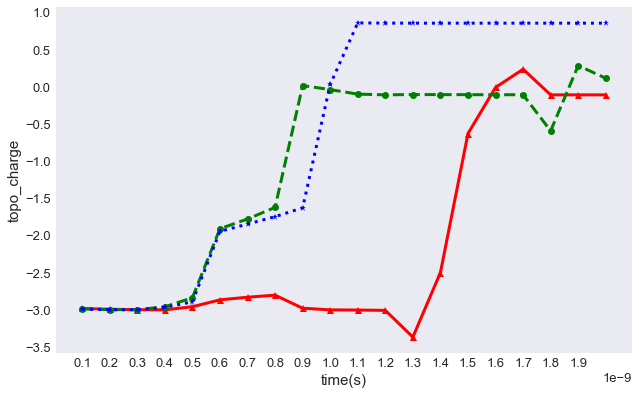

In [37]:
from cycler import cycler
my_cycler=(cycler(color=['r','g','b','y'])+cycler(linestyle=['-','--',':','-.']))
fig=plt.figure(figsize=(10,8))
ax=fig.add_axes([0.2,0.5,0.8,0.6])
ax.set_prop_cycle(my_cycler)
ax.set_xlabel('time(s)')
ax.set_ylabel('topo_charge')
ax.set_xticks(np.arange(0,20e-10,1e-10))
ax.set_yticks(np.arange(-3.5,2,0.5))
ax.plot(x,topo_charge1,linewidth=3,marker='^')
ax.plot(x,topo_charge4,linewidth=3,marker='o')
ax.plot(x,topo_charge5,linewidth=3,marker='*')

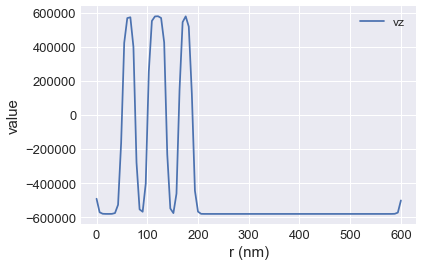

In [15]:
data[66][0].line(p1=(-l,0,0),p2=(l,0,0),n=100).mpl(yaxis=['vz'])